# Polarization

This is a short tutorial for modeling polarized X-ray flux from a rapidly rotating neutron star. Detailed discussions on the formation of polarization can be found in [Loktev et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020A%26A...643A..84L/abstract)

For MSPs, polarization arises from Thomson scattering or comptonization by an accretion shock formed above the hot region. In the case of Thomson scattering, the degree of polarization depends on the angle of propagation respect to the local surface normal. The polarization angle change from the emission site to the observer is governed by the rotating vector model, which incorporates the oblate shape of the NS and relativistic effects due to the rapid rotation. This simple case is implemented in this tutorial. For the case of comptonized atmosphere, details can be found in [Bobrikova et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...678A..99B/abstract)

It is important to note that although the magnetic field of the MSP does not influence radiative transfer within the atmospheric slab (i.e., the atmosphere is treated as non-magnetic), it does play a crucial role in shaping and forming the hot spots (HSs).

Let us first make the initial setup (see the Modeling tutorial for more detailed explanations):

And then let us make the final integration and plot the results for all Stokes parameters. 

We first check Stokes I profiles (integrated over all energies) for the primary and secondary hot spots:

In [1]:
%matplotlib inline

from __future__ import print_function, division

import os
import numpy as np
import math
import time

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm

import xpsi

from xpsi.global_imports import _c, _G, _dpr, gravradius, _csq, _km, _2pi


freq = 600.0

bounds = dict(distance = (0.1, 1.0),                     # (Earth) distance
                mass = (1.0, 3.0),                       # mass
                radius = (3.0 * gravradius(1.0), 16.0),  # equatorial radius
                cos_inclination = (0.0, 1.0))            # (Earth) inclination to rotation axis

spacetime = xpsi.Spacetime(bounds=bounds, values=dict(frequency=freq))


ceding = False

bounds = dict(super_colatitude = (None, None),
              super_radius = (None, None),
              phase_shift = (0.0, 0.1),
              super_temperature = (None, None))

if ceding:

    bounds = dict(super_colatitude=(None,None),
                  super_radius = (None, None),
                  phase_shift = (0.0, 1.0),
                  super_temperature = (None, None),
                  cede_colatitude = (None, None),
                  cede_radius = (None, None),
                  cede_azimuth = (None, None),
                  cede_temperature = (None, None))

# a simple circular, simply-connected spot
primary = xpsi.HotRegion(bounds=bounds,
                            values={}, # no initial values and no derived/fixed
                            symmetry=True,
                            #symmetry=False,
                            omit=False,
                            cede=ceding,
                            concentric=False,
                            sqrt_num_cells=32,
                            min_sqrt_num_cells=10,
                            max_sqrt_num_cells=64,
                            #num_leaves=100,
                            num_leaves=121,
                            num_rays=200,
                            do_fast=False,
                            atm_ext="Pol_BB_Burst",
                            prefix='p')


class derive(xpsi.Derive):
    def __init__(self):
        """
        We can pass a reference to the primary here instead
        and store it as an attribute if there is risk of
        the global variable changing.

        This callable can for this simple case also be
        achieved merely with a function instead of a magic
        method associated with a class.
        """
        pass

    def __call__(self, boundto, caller = None):
        # one way to get the required reference
        global primary # unnecessary, but for clarity
        return primary['super_temperature'] - 0.2

bounds['super_temperature'] = None # declare fixed/derived variable

secondary = xpsi.HotRegion(bounds=bounds, # can otherwise use same bounds
                              values={'super_temperature': derive()}, # create a callable value
                              symmetry=True,
                              omit=False,
                              cede=ceding,
                              concentric=False,
                              sqrt_num_cells=32,
                              min_sqrt_num_cells=10,
                              max_sqrt_num_cells=100,
                              num_leaves=100,
                              num_rays=200,
                              do_fast=False,
                              atm_ext="Pol_BB_Burst", #the simplest polarized atmosphere extension
                              is_antiphased=True,
                              prefix='s') # unique prefix needed because >1 instance

from xpsi import HotRegions

hot = HotRegions((primary, secondary))

h = hot.objects[0]

hot['p__super_temperature'] = 6.0 # equivalent to ``primary['super_temperature'] = 6.0``


class CustomPhotosphere(xpsi.Photosphere):
    """ Implement method for imaging."""

    @property
    def global_variables(self):
        """ This method is needed if we also want to ivoke the image-plane signal simulator. """

        return np.array([self['p__super_colatitude'],
                          self['p__phase_shift'] * _2pi,
                          self['p__super_radius'],
                          self['p__super_temperature'],
                          self['s__super_colatitude'],
                          (self['s__phase_shift'] + 0.5) * _2pi,
                          self['s__super_radius'],
                          self.hot.objects[1]['s__super_temperature']])

bounds = dict(spin_axis_position_angle = (None, None))
#Set here stokes=True to calculate the polarized X-ray signal.
photosphere = CustomPhotosphere(hot = hot, elsewhere = None, stokes=True, bounds=bounds,
                                values=dict(mode_frequency = spacetime['frequency']))


print(photosphere['mode_frequency'] == spacetime['frequency'])

star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

#Let us first initialize the star with these values but change them later:
p = [1.4,
     12.5,
     0.2,
     math.cos(1.25),
     0.0,
     0.0,
     1.0,
     0.075,
     6.2,
     0.025,
     math.pi - 1.0,
     0.2]
if ceding:
    p = [1.4, #mass
         12.0, #radius
         0.2, #distance
         math.cos(1.25), #cos_inclination
         0.0, # spin_axis_position_angle
         0.0, #p__phase_shift
         1.0, #p__super_colatitude
         0.075, #p__super_radius
         6.2, #p__super_temperature
         0.1, #p__cede_colatitude
         0.1, #p__cede_radius
         0.0, #p__cede_azimuth
         6.2, #p__cede_temperature
         0.025, #s__phase_shift
         math.pi - 1.0, #s__super_colatitude
         0.2, #s__super_radius
         math.pi-1.0, #s__cede_colatitude ..
         0.3, #s__cede_radius
         0.0, #s__cede_azimuth
         6.2] #s__cede_temperature

star(p)


#These are the values used in the light curve computation:
star['mass'] = 1.4 #2.7088795
star['radius'] = 12.0 #20.0 #12.0
star['distance'] = 0.2
incl_deg = 40.0 #90.0 #40.0
star['cos_inclination'] = math.cos(math.pi*incl_deg/180.0)#math.cos(2.0)
theta_deg = 60.0
star['p__super_colatitude'] = math.pi*theta_deg/180.0 #0.0 #2.0
rho_deg = 10.0 #10.0 #0.001 #10.0
star['p__super_radius'] = math.pi*rho_deg/180.0
tplanck = 1.0219978 #1.0 #in keV #1 keV -> log10(T[K]) = 7.06 (out of bounds originally)
star['p__super_temperature'] = np.log10(tplanck*11604525.0061657)


if ceding:
    star['p__cede_colatitude'] = math.pi*theta_deg/180.0
    star['p__cede_azimuth'] = 0.0 #0.0
    star['p__cede_radius'] = math.pi*rho_deg/180.0+0.02
    star['p__cede_temperature'] = np.log10(tplanck*11604525.0061657)
    star['s__super_radius'] = math.pi*rho_deg/180.0
    star['s__super_colatitude'] = math.pi-math.pi*theta_deg/180.0
    star['s__cede_colatitude'] = math.pi-math.pi*theta_deg/180.0
    star['s__cede_azimuth'] = 0.1 #math.pi/2.0
    star['s__cede_radius'] = math.pi*rho_deg/180.0+0.02
    star['s__cede_temperature'] = np.log10(tplanck*11604525.0061657)


rcParams['text.usetex'] = False
rcParams['font.size'] = 14.0

def veneer(x, y, axes, lw=1.0, length=8):
    """ Make the plots a little more aesthetically pleasing. """
    if x is not None:
        if x[1] is not None:
            axes.xaxis.set_major_locator(MultipleLocator(x[1]))
        if x[0] is not None:
            axes.xaxis.set_minor_locator(MultipleLocator(x[0]))
    else:
        axes.xaxis.set_major_locator(AutoLocator())
        axes.xaxis.set_minor_locator(AutoMinorLocator())

    if y is not None:
        if y[1] is not None:
            axes.yaxis.set_major_locator(MultipleLocator(y[1]))
        if y[0] is not None:
            axes.yaxis.set_minor_locator(MultipleLocator(y[0]))
    else:
        axes.yaxis.set_major_locator(AutoLocator())
        axes.yaxis.set_minor_locator(AutoMinorLocator())

    axes.tick_params(which='major', colors='black', length=length, width=lw)
    axes.tick_params(which='minor', colors='black', length=int(length/2), width=lw)
    plt.setp(axes.spines.values(), linewidth=lw, color='black')

def plot_pulse(stokes="I"):
    """ Plot hot region signals before telescope operation. """
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)

    #ax.set_ylabel('Signal [arbitrary normalisation]')
    ax.set_xlabel('Phase [cycles]')

    if stokes=="I":
        temp1 = np.sum(photosphere.signal[0][0], axis=0)
        temp2 = np.sum(photosphere.signal[1][0], axis=0)
        ax.set_ylabel('Signal Stokes I/max(I)')
    elif stokes=="Q":
        temp1 = np.sum(photosphere.signalQ[0][0], axis=0)
        temp2 = np.sum(photosphere.signalQ[1][0], axis=0)
        ax.set_ylabel('Signal Stokes Q/max(|Q|)')
    elif stokes=="U":
        temp1 = np.sum(photosphere.signalU[0][0], axis=0)
        temp2 = np.sum(photosphere.signalU[1][0], axis=0)
        ax.set_ylabel('Signal Stokes U/max(|U|)')

    else:
         print("ERROR: Stokes option must be 'I', 'Q', or 'U'")
         exit()

    ax.plot(hot.phases_in_cycles[0], temp1/np.max(abs(temp1)), 'o-', color='k', lw=0.5, markersize=2,label='Primary HS')
    ax.plot(hot.phases_in_cycles[1], temp2/np.max(abs(temp2)), 'o-', color='r', lw=0.5, markersize=2,label='Secondary HS')
    ax.legend()

    veneer((0.05,0.2), (0.05,0.2), ax)

    #fig.savefig("figs/pulse_profile"+stokes+"X.pdf")

nene = 281 #128

from numpy import logspace
from numpy import log
evere=0.5109989e6 # electron volts in elecron rest energy
x_l, x_u = -3.7 , .3 # lower and upper bounds of the log_10 energy span
IntEnergy = logspace(x_l,x_u,nene), log(1e1)*(x_u-x_l)/(nene-1.)
x, x_weight = IntEnergy
energies = (x*evere)/1e3

star.update() #Calculating the space-time integrals etc.


import time

primary.image_order_limit = 1


/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 3.0.0               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported emcee version: 3.1.6
Imported PyMultiNest.
Imported UltraNest.
Imported GetDist version: 1.5.3
Imported nestcheck version: 0.2.1
Creating parameter:
    > Named "frequency" with fixed value 6.000e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-01, 1.000e+00].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [0.000e+00, 1.000e+00].

Time spent in integration (unpolarized): 3.8012921810150146


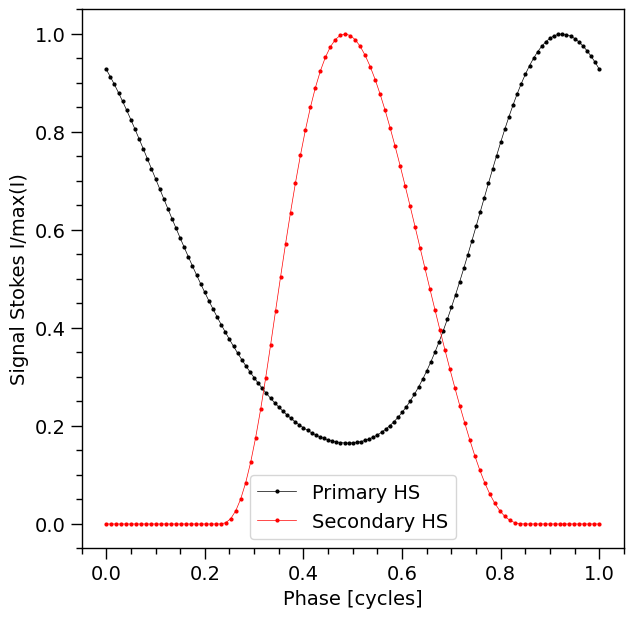

In [2]:
start = time.time()
photosphere.integrate(energies, threads=1) 
end = time.time()
print("Time spent in integration (unpolarized):",end - start)

plot_pulse(stokes="I") 

Let us also check Stokes Q and U profiles:

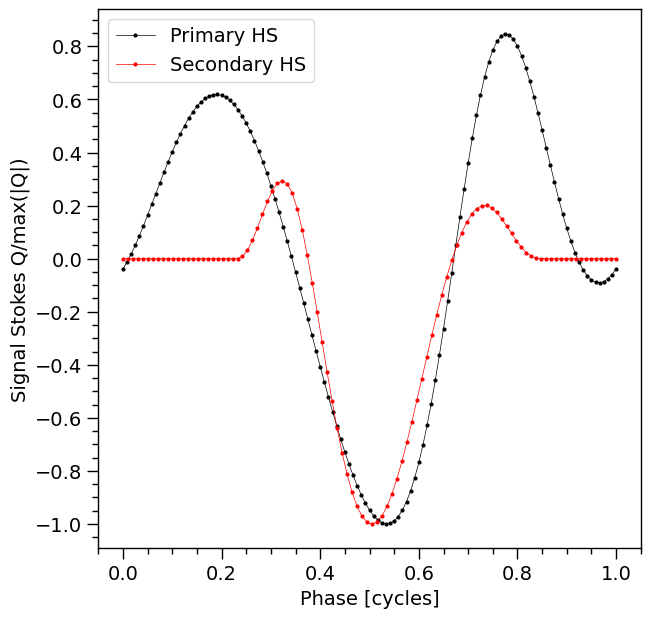

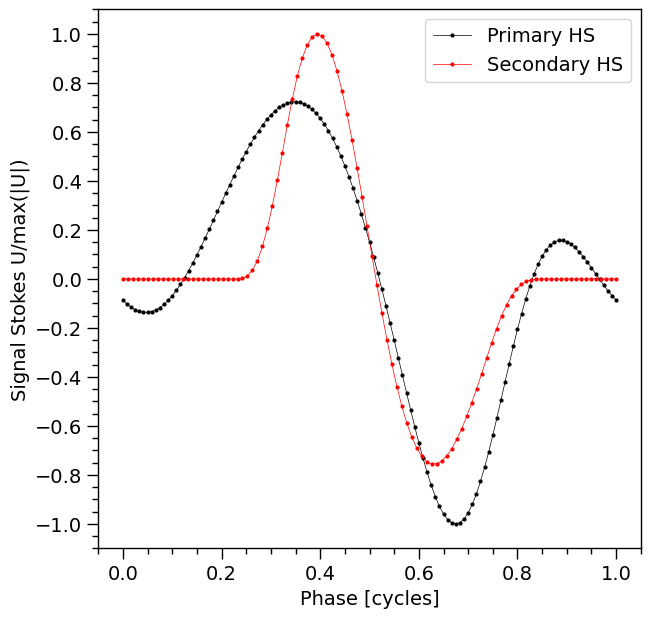

In [3]:
plot_pulse(stokes="Q") 
plot_pulse(stokes="U") 

Next, we sum the Stokes parameters for the primary and secondary HS and construct a color-coded plot representing the total Stokes parameters Q and U as a vector diagram. The color gradient corresponds to the pulse phase, as indicated in the subplot displaying the pulse profile.

In [4]:
from matplotlib.collections import LineCollection

def plot_QUplane():
    """ Plot Stokes in the Q-U plane """
    fig = plt.figure(figsize=(7,7))
    ax1 = fig.add_subplot(111)
    
    ax1.set_xlabel(r'$100 \times Q/I_{max}$')    
    ax1.set_ylabel(r'$100 \times U/I_{max}$')

    ph = hot.phases_in_cycles[0]
    I1 = np.sum(photosphere.signal[0][0], axis=0)
    Q1 = np.sum(photosphere.signalQ[0][0], axis=0)
    U1 = np.sum(photosphere.signalU[0][0], axis=0)

    I2 = np.interp(ph, hot.phases_in_cycles[1], np.sum(photosphere.signal[1][0], axis=0))
    Q2 = np.interp(ph, hot.phases_in_cycles[1], np.sum(photosphere.signalQ[1][0], axis=0))
    U2 = np.interp(ph, hot.phases_in_cycles[1], np.sum(photosphere.signalU[1][0], axis=0))
    
    Itot = I1 + I2
    Qntot = 100*(Q1 + Q2)/np.max(Itot)
    Untot = 100*(U1 + U2)/np.max(Itot)

    ax1.axis([1.1*np.min(Qntot),1.1*np.max(Qntot),1.1*np.min(Untot),2.7*np.max(Untot)]) #set axis limits. This is [xlow, xhigh, ylow, yhigh]

    segments = [np.column_stack([Qntot[i:i+2], Untot[i:i+2]]) for i in range(len(Qntot) - 1)]    
    lc = LineCollection(segments, cmap='hsv',array=ph,linewidth=4)
    line = ax1.add_collection(lc)
    
    l, b, h, w = .45, .65, .2, .4
    ax2 = fig.add_axes([l, b, w, h])
    segments = [np.column_stack([ph[i:i+2], Itot[i:i+2]/np.max(Itot)]) for i in range(len(ph) - 1)]
    ax2.axis([0,1,0,1.1])
    lc = LineCollection(segments, cmap='hsv',array=ph,linewidth=4)
    line = ax2.add_collection(lc)
    ax2.set_xlabel('phase')
    ax2.set_ylabel(r'$I\,/I_\mathrm{max}$')
    veneer((0.05,0.2), (0.05,0.2), ax1)
    veneer((0.05,0.2), (0.05,0.2), ax2)

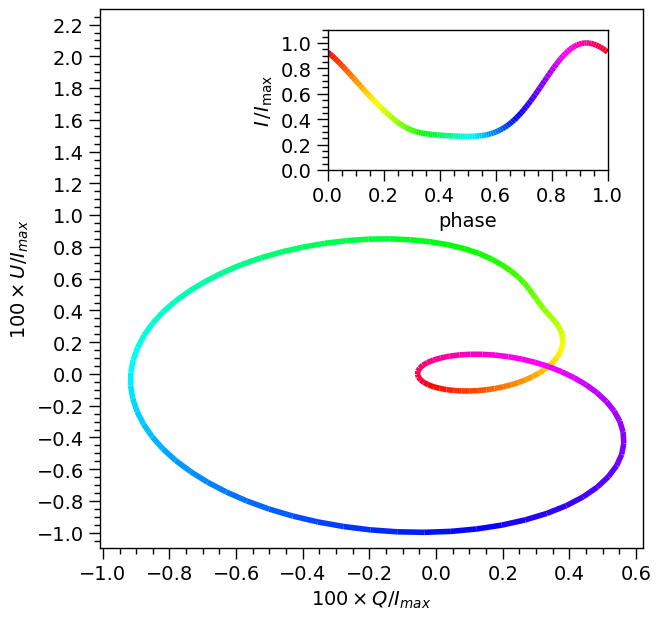

In [5]:
plot_QUplane()

## Creating synthetic data

To produce polarized synthetic data, we can couple X-PSI to ixpeobssim as an input model. The input model file needs to be placed in the `config` folder of the [ixpeobssim repository](https://github.com/lucabaldini/ixpeobssim) . An example of the input model file is provided [here](https://github.com/xpsi-group/xpsi/tree/main/examples/examples_modeling_tutorial/ixpeobssim/config/model_amsp_xpsi.py). To prodcue the synthetic Stokes profiles and their associated errors one should execute `source setup.sh` in the main directory of ixpeobssim and then run a script like `simulate_amsp_xpsi.py` found [here](https://github.com/xpsi-group/xpsi/tree/main/examples/examples_modeling_tutorial/ixpeobssim/simulate_amsp_xpsi.py). For more details, check the ixpeobssim documentation [pages](https://ixpeobssim.readthedocs.io/en/latest/?badge=latest).

## Fitting the data

Modeling X-ray polarized data using Bayesian inference is not yet part of this tutorial. However, a preliminary example of a such procedure can be found in this example script: [TestRun_PolNum_split_inference.py](https://github.com/xpsi-group/xpsi/blob/main/examples/examples_modeling_tutorial/TestRun_PolNum_split_inference.py).